In [4]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# By Orders

In [5]:
df = pd.read_csv('Dataset/top8_coffee_orders_by_column.csv')

In [6]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [7]:
df.head()

,datetime,americano,americano with milk,cappuccino,cocoa,cortado,espresso,hot chocolate,latte
0,2024-03-01 10:15:00,0,0,0,0,0,0,0,1
1,2024-03-01 12:19:00,0,0,0,0,0,0,1,0
2,2024-03-01 12:20:00,0,0,0,0,0,0,1,0
3,2024-03-01 13:46:00,1,0,0,0,0,0,0,0
4,2024-03-01 13:48:00,0,0,0,0,0,0,0,1


In [8]:
df = df.resample('h', on='datetime').sum().reset_index()

In [9]:
df.head()

,datetime,americano,americano with milk,cappuccino,cocoa,cortado,espresso,hot chocolate,latte
0,2024-03-01 10:00:00,0,0,0,0,0,0,0,1
1,2024-03-01 11:00:00,0,0,0,0,0,0,0,0
2,2024-03-01 12:00:00,0,0,0,0,0,0,2,0
3,2024-03-01 13:00:00,1,0,0,0,0,0,0,1
4,2024-03-01 14:00:00,0,0,0,0,0,0,0,0


In [10]:
# List of coffee types (excluding datetime)
coffee_types = ['americano', 'americano with milk', 'cappuccino', 'cocoa', 'cortado',
                'espresso', 'hot chocolate', 'latte']

# Dictionary to store the individual DataFrames
coffee_dfs = {}

# Create one DataFrame per coffee type
for coffee in coffee_types:
    coffee_dfs[coffee] = df[['datetime', coffee]].copy()

22:59:05 - cmdstanpy - INFO - Chain [1] start processing
22:59:09 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


Prophet MAE: 0.18
Prophet RMSE: 0.25


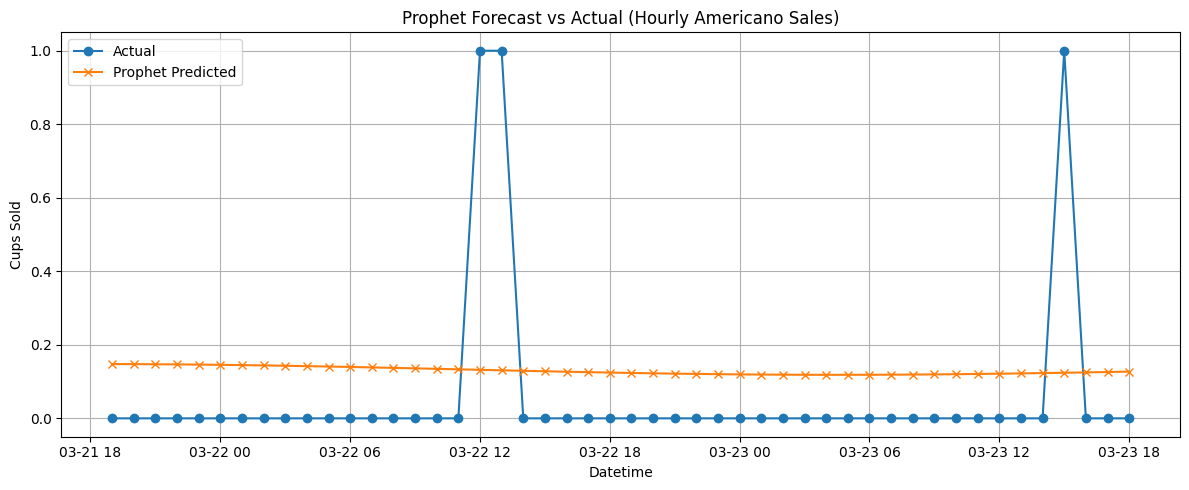

In [ ]:
# Step 1: Prepare data
df = coffee_dfs['americano'].rename(columns={'datetime': 'ds', 'americano': 'y'})

df['y'] = np.log1p(df['y'])

# Step 2: Split into train and test sets
# Use last 2 days (48 hours) as test
train_df = df[:-48]
test_df = df[-48:]

# Step 3: Train the model on the training set
model = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True 
)
model.add_seasonality(name='hourly', period=24, fourier_order=6)
model.fit(train_df)

# Step 4: Create future DataFrame for next 48 timestamps
future = model.make_future_dataframe(periods=48, freq='h')

# Step 5: Predict
forecast = model.predict(future)

# Step 6: Inverse transform and clip
forecast['yhat'] = np.expm1(forecast['yhat'])
forecast['yhat'] = forecast['yhat'].clip(lower=0)

# Step 7: Evaluation on test set only
forecast_test = forecast[-48:].copy()  # last 48 forecasted rows
y_true = np.expm1(test_df['y'].values)  # original scale of test target
y_pred = forecast_test['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Prophet MAE: {mae:.2f}")
print(f"Prophet RMSE: {rmse:.2f}")

# Step 8: Plot forecast vs actual
plt.figure(figsize=(12, 5))
plt.plot(test_df['ds'], y_true, label='Actual', marker='o')
plt.plot(test_df['ds'], y_pred, label='Prophet Predicted', marker='x')
plt.title("Prophet Forecast vs Actual (Hourly Americano Sales)")
plt.xlabel("Datetime")
plt.ylabel("Cups Sold")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()